In [59]:
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
# %pylab inline

In [60]:
sess = tf.InteractiveSession() 
devices = sess.list_devices()
for d in devices:
    print(d.name)
sess.close()

/job:localhost/replica:0/task:0/device:CPU:0


### Realize simple NNet with Tensorflow on MNIST dataset
baselines:

0) Custom Logistic Regressison (TF in-class) ~ 0.9086 (9%)

Need to achived:  Accuracy 0.9840 (Error Rate 1,6%)

http://yann.lecun.com/exdb/mnist/

1) 2-layer NN, 300 HU, 1998, Y. LeCun

2) 2-layer NN, 800 HU, 2003, P. Simard


In [70]:
from tensorflow.keras.datasets import mnist

def load_dataset(val_prop = 1/6, normalize = True, flatten = False):
    '''function from hse-class (utility 7/10) - extended'''
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # normalize input matrix
    if normalize:
        X_train = X_train.astype(float) / 255.
        X_test = X_test.astype(float) / 255.

    # train-validation partitioning
    PROP_VALUE = int(round(X_train.shape[0]*val_prop,0))
    X_train, X_val = X_train[:-PROP_VALUE], X_train[-PROP_VALUE:]
    
    # make OHE-trasformation for target
    def np_ohe(x, uniq):
        return np.array([(x == i)*1 for i in uniq]).T
    
    y_train = np_ohe(y_train, np.unique(y_train).tolist())
    y_train, y_val = y_train[:-PROP_VALUE], y_train[-PROP_VALUE:]
    y_test = np_ohe(y_test, np.unique(y_test).tolist())
    
    if flatten: 
        X_train = X_train.reshape(-1,28**2)
        X_val = X_val.reshape(-1,28**2)
        X_test = X_test.reshape(-1,28**2)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten = True)

In [72]:
print('X: train, val, test',X_train.shape,X_val.shape,X_test.shape,sep='\n')
print('y: train, val, test',y_train.shape,y_val.shape,y_test.shape,sep='\n')

X: train, val, test
(50000, 784)
(10000, 784)
(10000, 784)
y: train, val, test
(50000, 10)
(10000, 10)
(10000, 10)


Number: 5


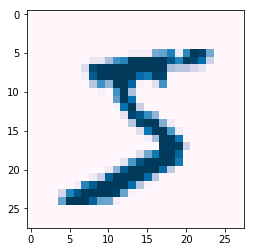

In [73]:
print('Number:',np.argmax(y_train[0]))
plt.imshow(X_train[0].reshape(28,28), cmap='PuBu');

In [76]:
# NOTES (How to make custom layers - maybe way)

# # 
# def fullyconnected_layer(x, input_size, out_size):
#     W = tf.Variable(tf.truncated_normal([input_size, out_size], stddev=0.1))
#     b = tf.Variable(tf.truncated_normal([out_size], stddev=0.1))
#     return tf.nn.relu(tf.matmul(x,W) + b)
# # 
# def softmax_layer(x, input_size, out_size):
#     W = tf.Variable(tf.truncated_normal([input_size, out_size], stddev=0.1))
#     b = tf.Variable(tf.truncated_normal([out_size], stddev=0.1))
#     return tf.nn.softmax(tf.matmul(x,W) + b)
# # 

...

In [82]:
# Use someone else's code to achieve their goals. (c) Unknown Programmer

from IPython import display

def visualize(l1,l2, h1, h2):
    '''function from hse-class (utility 10/10)'''
    plt.figure(figsize=(20,5)) 
    epo_range = range(1,len(h1)+1)
    tick_range = range(1,len(h1)+1,2)
    plt.subplot(1,2,1)
    plt.title('Learning loss')
    plt.plot(epo_range,l1, label='train set')
    plt.plot(epo_range,l2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.legend(title = 'Loss at:')
    
    plt.subplot(1,2,2)
    plt.title('Learning accuracy')
    plt.plot(epo_range,h1, label='train set')
    plt.plot(epo_range,h2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.ylim(0, 1.)
    plt.legend(title = 'Accuracy at:')
    
    display.clear_output(wait=True)
    plt.show()
    
# for branch approach (use later)
def batches_generator(X, y, batch_size):
    '''function from hse-class (utility 8/10)'''
    n_batches = int(X.shape[0]/batch_size) + 1
    for batch_idx in range(n_batches):
        indices = (batch_idx*batch_size, min(X.shape[0], (batch_idx+1)*batch_size))
        yield X[indices[0]:indices[1]], y[indices[0]:indices[1]]


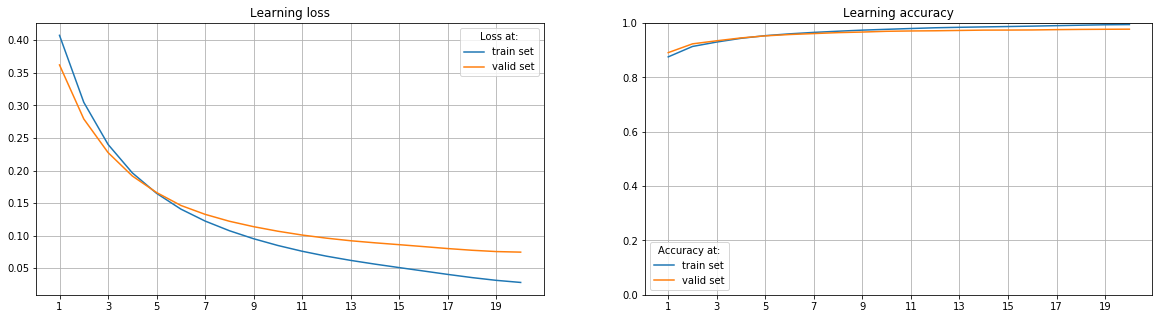

Accuracy (test): 0.977
Model saved in path: /tmp/model.ckpt


In [121]:
# MY SWEET BLOODY CODE

# ------------------------------------------------------------------------------------------
# MAKE GRAPH
# ------------------------------------------------------------------------------------------

# INPUT / OUTPUT DATA
input_0, output_1 = X_train.shape, y_train.shape

input_X = tf.placeholder(dtype='float32',shape=(None, input_0[1]))
input_y = tf.placeholder(dtype='float32',shape=(None, output_1[1]))


# 2-L-nnet structure (first N equal input, 1 hidden, N_hidden = 300)
L1_in, L1_out = input_0[1], 300
L2_in, L2_out = L1_out, output_1[1]

W1 = tf.Variable(tf.truncated_normal([L1_in, L1_out], stddev=0.1))
b1 = tf.Variable(tf.truncated_normal([L1_out], stddev=0.1))
A1 = tf.nn.relu(tf.matmul(input_X,W1) + b1)

W2 = tf.Variable(tf.truncated_normal([L2_in, L2_out], stddev=0.1))
b2 = tf.Variable(tf.truncated_normal([L2_out], stddev=0.1))
A2 = tf.nn.softmax(tf.matmul(A1,W2) + b2)

# loss function
# loss = tf.losses.softmax_cross_entropy(input_y, A2)
loss = tf.reduce_mean(-tf.reduce_sum(input_y*tf.log(A2), reduction_indices=1)) 


# quality metrics
correct_prediction = tf.equal(tf.argmax(A2, 1), tf.argmax(input_y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# gradient descent 
optimizer = tf.train.AdamOptimizer(0.0005, 0.99, 0.99, 1e-6).minimize(loss, var_list=[W1, b1, W2, b2])


# ------------------------------------------------------------------------------------------
## INIT SESSION
# ------------------------------------------------------------------------------------------

np.random.seed(42)   # для воспроизводимости

n_epochs = 20        # число эпох для обучения 
batch_size = 512     # размер одного батча 

sess = tf.InteractiveSession()                 # запускаем сессию для вычислений 
sess.run(tf.global_variables_initializer())    # инициализируем переменные 

saver = tf.train.Saver() # ВАЖНО! Сохраним весь стафф на диск.

# будем писать значения метрик в вектора 
loss_train, loss_val  = [ ], [ ] 
acc_train, acc_val = [ ], [ ]


# ------------------------------------------------------------------------------------------
## RUN GRAPH
# ------------------------------------------------------------------------------------------

for i in range(n_epochs):
    
    # сгенерировали батчи 
    batch_gen = batches_generator(X_train, y_train, batch_size)
    
    # пошёл цикл по батчам 
    for X_batch, y_batch in batch_gen:
        # итерация градиентного спуска на текущем батче 
        sess.run(optimizer, {input_X: X_batch, input_y: y_batch})
    
    # посмотрим на качество модели на трэйне и валидации
    loss_train.append(sess.run(loss, {input_X: X_train, input_y: y_train}))
    loss_val.append(sess.run(loss, {input_X: X_val, input_y: y_val}))
    
    acc_train.append(sess.run(accuracy, {input_X: X_train, input_y: y_train}))
    acc_val.append(sess.run(accuracy, {input_X: X_val, input_y: y_val}))
    
    # визуализируем
    visualize(loss_train, loss_val, acc_train, acc_val) 

print("Accuracy (test): %s" %sess.run(accuracy, {input_X: X_test, input_y: y_test}))

save_path = saver.save(sess, "/tmp/model.ckpt")
print("Model saved in path: %s" % save_path)

sess.close()

In [ ]:
## Лучшее - враг хорошего. Остановимся на этом. Дело за фитом гиперпараметров, а именно настройке оптимайзера

In [122]:
sess = tf.InteractiveSession() 
saver.restore(sess, "/tmp/model.ckpt")
print("Model restored.")

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
Model restored.


In [123]:
print("Accuracy (test): %s" %sess.run(accuracy, {input_X: X_test, input_y: y_test}),'(restored)')

Accuracy (test): 0.977 (restored)


In [124]:
sess.close()